In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from scipy.stats import zscore

# Sklearn imports for scaling, splitting, modeling, evaluation, and hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Additional libraries for boosting models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [4]:
# Example: Download data using yfinance library (install it if needed: pip install yfinance)
import yfinance as yf

# Define the ticker symbol (e.g., "AAPL" for Apple Inc.)
ticker = "AAPL"

# Download historical data (last 5 years)
data = yf.download(ticker, period="5y", interval="1d")

# Save the data to a CSV file for later use
data.to_csv("data/stock_data.csv")

# Display the first few rows
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-03-04,73.468651,73.628820,71.136509,71.939776,219178400
2020-03-05,71.085526,72.694481,70.719078,71.716485,187572800
2020-03-06,70.141510,70.575907,68.248617,68.435477,226176800
2020-03-09,64.593872,67.486602,63.824576,64.006586,286744800
2020-03-10,69.246040,69.512989,65.370456,67.256077,285290000


In [5]:
df = pd.read_csv(
    "data/stock_data.csv",
    skiprows=3,                # Skip the first two lines
    names=["Date", "Close", "High", "Low", "Open", "Volume"]
)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
print(df.head())
print("\nData Description:")
print(df.describe())


                Close       High        Low       Open     Volume
Date                                                             
2020-03-04  73.468651  73.628820  71.136509  71.939776  219178400
2020-03-05  71.085526  72.694481  70.719078  71.716485  187572800
2020-03-06  70.141510  70.575907  68.248617  68.435477  226176800
2020-03-09  64.593872  67.486602  63.824576  64.006586  286744800
2020-03-10  69.246040  69.512989  65.370456  67.256077  285290000

Data Description:
             Close         High          Low         Open        Volume
count  1256.000000  1256.000000  1256.000000  1256.000000  1.256000e+03
mean    157.429534   159.017701   155.661332   157.275070  8.713139e+07
std      42.130022    42.291982    41.878111    42.070240  5.051586e+07
min      54.449894    55.452160    51.595990    55.350235  2.323470e+07
25%     130.590248   131.919737   128.955920   130.634560  5.392302e+07
50%     154.884689   156.823942   152.105375   154.564515  7.408865e+07
75%     181.581

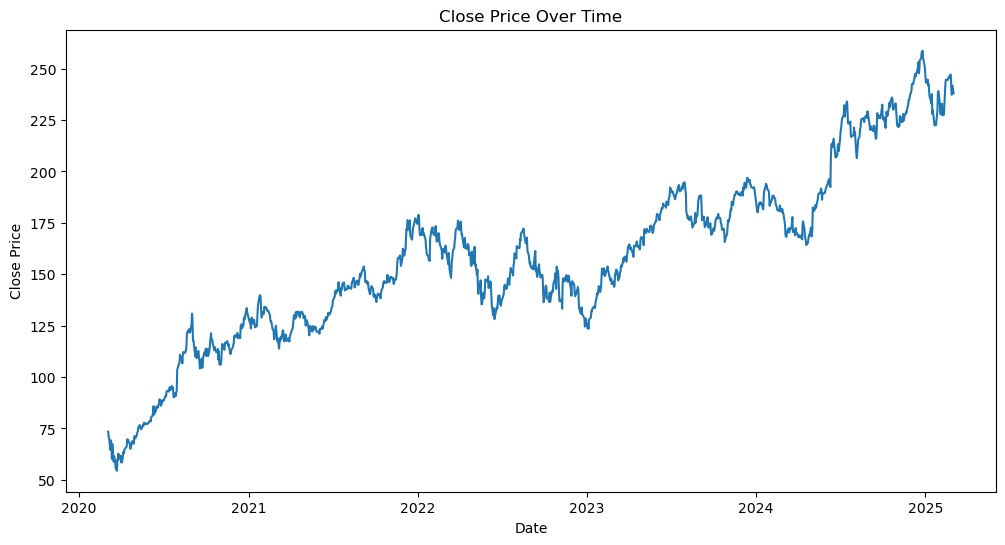

In [6]:
# Plot the Close price over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])
plt.title("Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [7]:
# ---------------------------
# Outlier Detection & Handling
# ---------------------------
# Remove outliers from the 'Close' column using a z-score threshold (|z| < 3)
df['Close_z'] = zscore(df['Close'])
df = df[df['Close_z'].abs() < 3]
df.drop(columns=['Close_z'], inplace=True)

In [8]:
# ---------------------------
# Feature Engineering
# ---------------------------
# Create Technical Indicators using ta (instead of pandas_ta)

# 1. Simple Moving Average (SMA) for a 20-day period
df['SMA20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()

# 2. Exponential Moving Average (EMA) for a 20-day period
df['EMA20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

# 3. Relative Strength Index (RSI) with a 14-day period
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

# 4. Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Hist'] = macd.macd_diff()

# Drop initial rows with NaNs after indicator calculations
df.dropna(inplace=True)

# Generate "Returns" Feature: daily percentage change in 'Close'
df['Return'] = df['Close'].pct_change()
df.dropna(inplace=True)

# Define the binary Target: 1 if next day's Close > today's, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df.dropna(inplace=True)

print(df.head())

                Close       High        Low       Open     Volume      SMA20  \
Date                                                                           
2020-04-22  67.003677  67.440497  66.057231  66.399402  116862400  64.062772   
2020-04-23  66.744019  68.374822  66.705189  66.947868  124814400  64.420846   
2020-04-24  68.670876  68.680585  67.222082  67.270620  126161200  64.718491   
2020-04-27  68.719421  69.051890  67.937995  68.386945  117087600  65.148397   
2020-04-28  67.605522  69.364945  67.513310  69.182936  112004800  65.436821   

                EMA20        RSI      MACD  MACD_Signal  MACD_Hist    Return  \
Date                                                                           
2020-04-22  65.404448  53.541258  0.788500     0.285353   0.503147  0.028804   
2020-04-23  65.532026  52.948988  0.778925     0.384067   0.394857 -0.003875   
2020-04-24  65.830964  56.770560  0.916256     0.490505   0.425751  0.028869   
2020-04-27  66.106056  56.865617  1.017

In [9]:
# ---------------------------
# Data Scaling
# ---------------------------
# Define feature columns; adjust as needed
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA20', 'EMA20', 'RSI', 
            'MACD', 'MACD_Signal', 'MACD_Hist', 'Return']
X = df[features]
y = df['Target']

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

In [10]:
# ---------------------------
# Train/Test Split: Chronological
# ---------------------------
train_size = int(len(X_scaled) * 0.8)
X_train = X_scaled.iloc[:train_size]
X_test  = X_scaled.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]

print("Training set size:", X_train.shape, " Testing set size:", X_test.shape)

Training set size: (977, 12)  Testing set size: (245, 12)


In [14]:
# Cell: Fetch and Process News Sentiment from a News API
import requests
import datetime
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Replace with your NewsAPI key
api_key = "44e0b7ac8f2247c18afa1ffc06168edd"

# Define a date range (for example, one day or a range)
# Use recent dates (e.g., last week) instead of 2022
start_date = datetime.date.today() - datetime.timedelta(days=7)
end_date = datetime.date.today()


daily_sentiments = []
sia = SentimentIntensityAnalyzer()

current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime("%Y-%m-%d")
    url = f"https://newsapi.org/v2/everything?q=Apple&from={date_str}&to={date_str}&sortBy=popularity&apiKey={api_key}"
    
    response = requests.get(url)
    if response.status_code == 200:
        news_data = response.json()
        headlines = [article['title'] for article in news_data.get('articles', [])]
        if headlines:
            sentiments = [sia.polarity_scores(headline)['compound'] for headline in headlines]
            avg_sentiment = np.mean(sentiments)
            daily_sentiments.append({'date': date_str, 'num_headlines': len(headlines), 'avg_sentiment': avg_sentiment})
            print(f"Date: {date_str} | Headlines: {len(headlines)} | Avg Sentiment: {avg_sentiment:.4f}")
        else:
            print(f"Date: {date_str} | No headlines found.")
    else:
        print(f"Error fetching news for {date_str}: {response.status_code}")
    current_date += datetime.timedelta(days=1)

# Check if data was collected
if not daily_sentiments:
    print("No sentiment data was collected.")
else:
    df_sentiment = pd.DataFrame(daily_sentiments)
    print("Keys in the sentiment data:", df_sentiment.columns)
    # Convert and set the index if the 'date' key is present
    if 'date' in df_sentiment.columns:
        df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
        df_sentiment.set_index('date', inplace=True)
    print("\nDaily aggregated sentiment:")
    print(df_sentiment)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Date: 2025-02-26 | Headlines: 97 | Avg Sentiment: 0.0408
Date: 2025-02-27 | Headlines: 100 | Avg Sentiment: 0.0427
Date: 2025-02-28 | Headlines: 99 | Avg Sentiment: 0.1026
Date: 2025-03-01 | Headlines: 98 | Avg Sentiment: 0.0793
Date: 2025-03-02 | Headlines: 99 | Avg Sentiment: 0.0863
Date: 2025-03-03 | Headlines: 98 | Avg Sentiment: 0.0679
Date: 2025-03-04 | No headlines found.
Date: 2025-03-05 | No headlines found.
Keys in the sentiment data: Index(['date', 'num_headlines', 'avg_sentiment'], dtype='object')

Daily aggregated sentiment:
            num_headlines  avg_sentiment
date                                    
2025-02-26             97       0.040825
2025-02-27            100       0.042677
2025-02-28             99       0.102598
2025-03-01             98       0.079300
2025-03-02             99       0.086329
2025-03-03             98       0.067860
